In [2]:
import pandas as pd
import numpy as np

## Data Formatting

In [6]:
## Read in raw data, downloaded directly from ultianalytics.com
## Replace filename with your data's filename
## Raw data should be in the /dat/ folder
filename = '../dat/SanJoseSpiders2017.csv'
raw = pd.read_csv(filename)
raw.head(6)

,Date/Time,Tournamemnt,Opponent,Point Elapsed Seconds,Line,Our Score - End of Point,Their Score - End of Point,Event Type,Action,Passer,...,Begin Area,Begin X,Begin Y,End Area,End X,End Y,Distance Unit of Measure,Absolute Distance,Lateral Distance,Toward Our Goal Distance
0,2017-04-21 19:21,AUDL,San Diego Growlers,18,D,0,1,Defense,Pull,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-04-21 19:21,AUDL,San Diego Growlers,18,D,0,1,Defense,Goal,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-04-21 19:21,AUDL,San Diego Growlers,101,O,1,1,Offense,Catch,Steven C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-04-21 19:21,AUDL,San Diego Growlers,101,O,1,1,Offense,Catch,Chuck C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-04-21 19:21,AUDL,San Diego Growlers,101,O,1,1,Offense,Catch,Evan Bo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2017-04-21 19:21,AUDL,San Diego Growlers,101,O,1,1,Offense,Throwaway,Justin N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The ultianalytics data is fairly comprehensive: each row in the dataframe is an action that occurs on the field (catch, goal, turnover, etc.).

### Feature Extraction and Engineering

We are primarily interested in the 7 players on the field as our features, and the outcome of the point as our target. Other predictors that we can use include whether the point is an O point or a D point (for high level teams, we would expect O points to be scored more often), and the number of points played prior to this point (some teams are stronger later or earlier in the game).

Other data that is useful to see (but can't be used as predictors because they are not known before starting a point) include the number of passes completed in a point, the number of possessions during a point, and the duration of a point.

In [3]:
raw[['Player 0','Player 1','Player 2','Player 3','Player 4','Player 5','Player 6']].head(6)

,Player 0,Player 1,Player 2,Player 3,Player 4,Player 5,Player 6
0,Kelly V,Sonny Z,Jon G,Matthe C,Brando F,Ethan F,James Y
1,Kelly V,Sonny Z,Jon G,Matthe C,Brando F,Ethan F,James Y
2,Evan Br,Steven C,Jackso S,Chuck C,Evan Bo,Justin N,Shane E
3,Evan Br,Steven C,Jackso S,Chuck C,Evan Bo,Justin N,Shane E
4,Evan Br,Steven C,Jackso S,Chuck C,Evan Bo,Justin N,Shane E
5,Evan Br,Steven C,Jackso S,Chuck C,Evan Bo,Justin N,Shane E


In [4]:
## Get a list of all the players on the team
players = pd.unique(raw[['Player 0','Player 1','Player 2','Player 3','Player 4','Player 5','Player 6']].values.ravel())
players = players.astype(str)
players = players[~np.isin(players,['nan','Anonymous'])]
players = pd.Series(players).sort_values()

In [5]:
## Drop columns that will not be useful for us
raw = raw[['Opponent','Point Elapsed Seconds','Line','Our Score - End of Point','Their Score - End of Point',
           'Event Type','Action','Passer','Receiver','Defender','Player 0','Player 1','Player 2','Player 3','Player 4',
          'Player 5','Player 6','Player 7','Player 8']]
## Ignore Cessations. In the AUDL it is possible for a point to end without a goal
## (in this case, the point is stopped by the clock). We want to remove any actions that occur between
## The last goal and a cessation.
## This should have no effect on non-AUDL teams.
cess_ind = raw[raw['Event Type'] == 'Cessation'].index.values
if len(cess_ind > 0):
    goal_ind = raw[raw['Action'] == 'Goal'].index.values
    ignore_ind = list()
    for i in cess_ind:
        last_goal = max(goal_ind[goal_ind < i])
        ignore_ind.extend(list(range(last_goal+1,i+1)))
    raw.drop(ignore_ind, inplace=True)
    raw.index = list(range(len(raw)))
## Count the number of completed passes in a point
goal_ind = raw[raw['Action'] == 'Goal'].index.values
pass_ind = (raw['Action'] == 'Catch') | ((raw['Action'] == 'Goal') & (raw['Event Type'] == 'Offense'))
passes = pass_ind.groupby(pd.cut(list(range(len(raw))),bins=np.insert(goal_ind,0,0), include_lowest=True)).sum()
## Count the number of possessions in a point
poss_ind = (raw['Action'] == 'Drop') | ((raw['Action'] == 'Throwaway') & (raw['Event Type'] == 'Offense')) | ((raw['Action'] == 'Goal') & (raw['Event Type'] == 'Offense'))
poss = poss_ind.groupby(pd.cut(list(range(len(raw))), bins=np.insert(goal_ind,0,0), include_lowest=True)).sum()
## Get the number of points played prior to starting the point
pts_played = raw[raw['Action'] == 'Goal']['Our Score - End of Point'] + raw[raw['Action'] == 'Goal']['Their Score - End of Point'] - 1
## Get the outcome of every point
outcome = (raw[raw['Action'] == 'Goal']['Event Type'] == 'Offense')*1
## Get the starting side of each point (1 for D, 0 for O)
line = (raw[raw['Action'] == 'Goal']['Line'] == 'D')*1
## Get the duration of every point
dur = raw[raw['Action'] == 'Goal']['Point Elapsed Seconds']
## Get the indicator variables for players on each point
dat = pd.DataFrame(raw[raw['Action'] == 'Goal'][['Player 0','Player 1','Player 2','Player 3','Player 4','Player 5','Player 6']].apply(lambda x:list(players.isin(x)*1), axis=1).tolist(), columns=list(players))
## Put all the other datapoints in the dataframe
dat['Duration'] = list(dur)
dat['Passes'] = list(passes)
dat['Possessions'] = list(map(int,poss))
dat['D Line'] = list(line)
dat['Points Played'] = list(pts_played)
dat['Outcome'] = list(outcome)
dat.head()

,Alec S,Andrew B,Andrew M,Andy S,Brando F,Chris C,Chuck C,David A,Drew K,Ethan F,...,Shane E,Sonny Z,Steven C,Tommy A,Duration,Passes,Possessions,D Line,Points Played,Outcome
0,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,18,0.0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,...,1,0,1,0,101,10.0,2,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,48,0.0,0,1,2,0
3,0,0,0,0,0,0,1,0,1,0,...,0,0,1,0,64,12.0,1,0,3,1
4,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,138,7.0,1,1,4,1


We now have our data in a format that is readable by machine learning algorithms, with a binary classification target.

## Visualizations

Before we start building models, let's try visualizing our data.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Scoring Ratio by Player

[Text(0.5,0,'Scored'), Text(0.5,1,'Scoring Ratio for Sonny Z')]

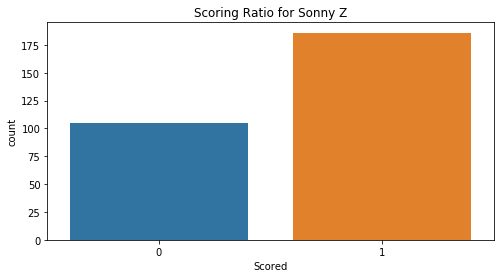

In [7]:
## Pick a number within the index of players
pl = 1
fig,ax = plt.subplots(figsize = (8,4))
sns.countplot(x = 'Outcome', data = dat[dat[players[pl]] == 1])
ax.set(xlabel='Scored', title = 'Scoring Ratio for ' + players[pl])

### Number of Passes Taken to Score

Text(0,0.5,'Count')

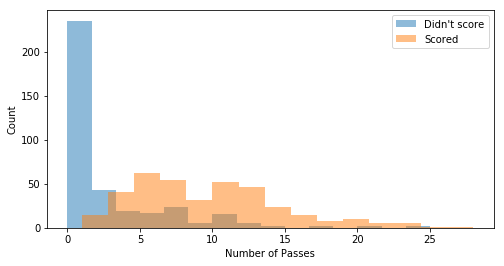

In [8]:
fig,ax = plt.subplots(figsize=(8,4))
plt.hist(dat[dat['Outcome']==0]['Passes'], bins = 15, alpha = 0.5, label = "Didn't score")
plt.hist(dat[dat['Outcome']==1]['Passes'], bins = 15, alpha = 0.5, label = "Scored")
plt.legend()
ax.set_xlabel('Number of Passes')
ax.set_ylabel('Count')

### Number of Passes Taken to Score - O-Line vs D-Line

Text(0,0.5,'Count')

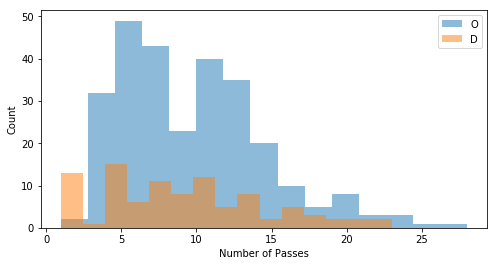

In [9]:
fig,ax = plt.subplots(figsize=(8,4))
plt.hist(dat[(dat['D Line'] == 0) & (dat['Outcome'] == 1)]['Passes'], bins = 15, alpha = 0.5, label = "O")
plt.hist(dat[(dat['D Line'] == 1) & (dat['Outcome'] == 1)]['Passes'], bins = 15, alpha = 0.5, label = "D")
plt.legend()
ax.set_xlabel('Number of Passes')
ax.set_ylabel('Count')

It looks like the average number of passes is about the same for both O-Line and D-Line - between 5 and 15 passes. D-Line scores less frequently than O-Line so their count is lower.

### Number of Possessions Taken to Score

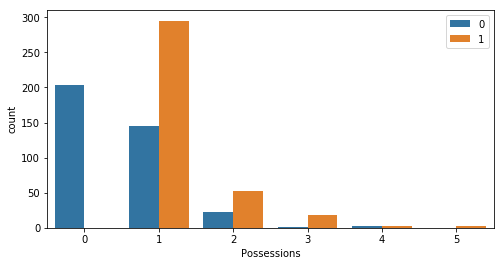

In [10]:
fig,ax = plt.subplots(figsize=(8,4))
sns.countplot(x = 'Possessions', data = dat, hue = 'Outcome')
plt.legend(loc = 'upper right')

This is a pretty expected trend:
* Never scored when there are 0 possessions (the opposing team scored without turning the disc over)
* The majority of scores happen in one possession.
* As the number of possessions increases, it appears that the chance of scoring actually remains the same, or even increases in the case of 3 possessions.

### Scoring Ratio by O-/D-Line

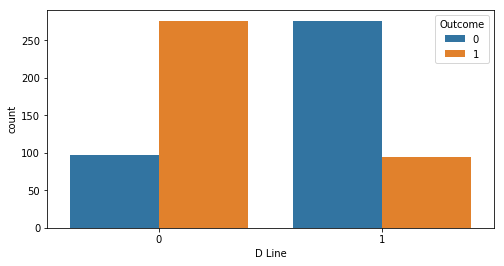

In [11]:
fig,ax = plt.subplots(figsize=(8,4))
sns.countplot(x = 'D Line', data = dat, hue = 'Outcome')

We would expect that the O-Line has a higher scoring ratio than the D-Line. In the case of the 2017 San Jose Spiders, there was an almost perfect symmetry between the O-Line and D-Line scoring ratios (coincidence).

### Duration of Points for O-/D-Line

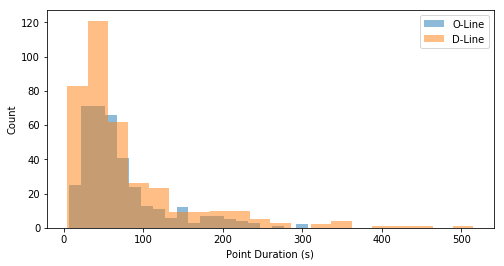

In [12]:
fig,ax = plt.subplots(figsize=(8,4))
plt.hist(x = dat[dat['D Line'] == 0]['Duration'], bins = 20, alpha = 0.5, label = 'O-Line')
plt.hist(x = dat[dat['D Line'] == 1]['Duration'], bins = 20, alpha = 0.5, label = 'D-Line')
ax.set_xlabel('Point Duration (s)')
ax.set_ylabel('Count')
plt.legend()

We see that O-Line tends to be on the field for slightly more seconds per point on average. We can check to see how the O-Line is doing compared to other teams' O-Lines by making the same plot, but only comparing O-Line to D-Line where the D-Line did not score (i.e. the other team's O-Line scored).

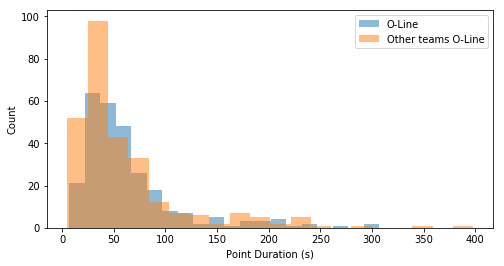

In [13]:
fig,ax = plt.subplots(figsize=(8,4))
plt.hist(x = dat[(dat['D Line'] == 0) & (dat['Outcome'] == 1)]['Duration'], bins = 20, alpha = 0.5, label = 'O-Line')
plt.hist(x = dat[(dat['D Line'] == 1) & (dat['Outcome'] == 0)]['Duration'], bins = 20, alpha = 0.5, label = 'Other teams O-Line')
ax.set_xlabel('Point Duration (s)')
ax.set_ylabel('Count')
plt.legend()

It looks like our O-Line is performing about the same as other teams' O-Lines, maybe taking slightly longer to score than other teams.

## Modeling and Predictions

We now aim to predict the outcome of a point, using the features we have created thus far.
Since the only features we would know prior to the start of the point are the players, our focus will be primarily on using the player features to make a predictions.

Model accuracy will be measured using k-fold cross validation (k=10). The target variable (outcome) is pretty evenly distributed between 0 and 1, so precision and recall scores are not totally necessary, but we can use them anyway.

### Model 1: Logistic Regression

As this is a binary classification problem, it makes sense to start with a standard logistic regression model.

In [7]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,classification_report

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dat.drop(['Duration','Passes','Possessions','Outcome'], axis=1), dat['Outcome'], test_size=0.2)
## Since these features are all indicator variables we can skip the scaling step.

In [16]:
## Fit a LogisticRegressionCV model
clf = LogisticRegressionCV(cv=10)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
## Check the accuracy
print('Cross validation score: %.2f' % 
      cross_val_score(clf, dat.drop(['Duration','Passes','Possessions','Outcome'], axis=1), dat['Outcome'], cv=10).mean())
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

Cross validation score: 0.75


[[60 19]
 [12 58]]


             precision    recall  f1-score   support

          0       0.83      0.76      0.79        79
          1       0.75      0.83      0.79        70

avg / total       0.80      0.79      0.79       149



So we have a logistic regression model that can predict outcome of a point with some degree of accuracy. One of the benefits of using a model where the players are the only features is that we get a coefficient assigned to each player. This coefficient can act as an indicator of the player's 'value' on the team: players that are on the field when scores occur have higher coefficients than ones that are on the field when getting scored on.

Of course, you can't assign a player's value to a single number. There is context behind these values. On high-level teams, sorting players by their coefficient tends to rank O-Line players at the top and D-Line players at the bottom. However, on lower level teams, such a sort produces a somewhat accurate 'good/bad' player ranking.

In [17]:
player_ranking = pd.Series(data = clf.coef_[0], index = dat.drop(['Duration','Passes','Possessions','Outcome'], axis=1).columns).sort_values(ascending = False)
player_ranking.drop(index = ['D Line','Points Played'])

Chuck C     0.036504
Steven C    0.035930
Jackso S    0.035077
Justin N    0.032677
Evan Br     0.029715
Shane E     0.028636
Andrew B    0.022906
Sonny Z     0.021829
Evan Bo     0.016765
Drew K      0.016514
Alec S      0.004779
Nick M      0.000800
Jake T      0.000146
Jacob S    -0.001292
Jon G      -0.004100
Kelly V    -0.005057
James Y    -0.007507
Sergio P   -0.008126
Matthe C   -0.008704
Nichol A   -0.010617
Chris C    -0.011892
Matt J     -0.013565
Ian S      -0.014274
Sam A      -0.015183
Jeremy K   -0.016002
Andy S     -0.016481
Tommy A    -0.016632
Mike D     -0.019066
Andrew M   -0.019163
Ian M      -0.019623
David A    -0.020363
Ethan F    -0.025923
Brando F   -0.029512
dtype: float64

### Testing Feature Importance

At the moment, the features we're working with are:
* All players on the team
* O Line or D Line
* Points played prior
We want to see if all our features are contributing to the model (particularly the last two, as we won't want to drop any player features).

We will use an F-test to see how each feature is doing.

In [42]:
from sklearn.feature_selection import f_classif

In [48]:
F,p = f_classif(dat.drop(['Duration','Passes','Possessions','Outcome'], axis=1), dat['Outcome'])
pd.DataFrame(data = {'F value':F,'p value':p},index = dat.drop(['Duration','Passes','Possessions','Outcome'], axis=1).columns)

,F value,p value
Alec S,3.638086,5.685817e-02
Andrew B,53.351632,7.218594e-13
Andrew M,59.635664,3.705701e-14
Andy S,35.577160,3.795036e-09
Brando F,68.770026,5.198974e-16
Chris C,36.319901,2.638367e-09
Chuck C,143.080378,2.830193e-30
David A,48.835170,6.211744e-12
Drew K,35.416515,4.105762e-09
Ethan F,74.899102,3.063383e-17


Results will vary depending on the team.

We are mostly interested in checking the statistics for the D-Line and Points Played features. The player features all have reasonable F and p values (some players that are lower impact or get little playing time may have high p-values, but we won't drop them). The D-Line statistic has a p-value that is equivalently 0, indicating that it is certainly an important predictor in determining the outcome of a point. The Points Played statistic, however, has a pretty high p-value, so it likely does not affect the outcome of a point.

Moving forward, we will not include the Points Played feature in our models, since it has little effect on the target.

### Feature Interaction

The next step is to test if interaction features can significantly improve the model. The hypothesis is that, beyond an individual player's contribution towards scoring or not scoring a point, having certain pairs or groups of players on a line make significantly more contributions (i.e. certain handler cores or cutter cores).

We will first inspect second order interaction terms, then third order interaction terms.

In [18]:
from sklearn.preprocessing import PolynomialFeatures

In [19]:
intx_generator = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
X_intx = intx_generator.fit_transform(dat.drop(['Duration','Passes','D Line','Possessions','Outcome','Points Played'], axis=1))
X_intx = pd.DataFrame(X_intx).join(dat['D Line'])
X_intx.shape

(743, 562)

For a team of 30 players, this will add a lot of interaction terms. We will later use dimensionality reduction to see if we can cut this down, but for now we want to see if these interaction terms actually improve the model.

In [20]:
Xintx_train, Xintx_test, yintx_train, yintx_test = train_test_split(X_intx, dat['Outcome'], test_size=0.2)
clf = LogisticRegressionCV(cv=10)
clf.fit(Xintx_train,yintx_train)
pred_intx = clf.predict(Xintx_test)
## Check accuracy
print('Cross validation score: %.2f' % 
      cross_val_score(clf, X_intx, dat['Outcome'], cv=10).mean())
print('\n')
print(confusion_matrix(yintx_test,pred_intx))
print('\n')
print(classification_report(yintx_test,pred_intx))

Cross validation score: 0.75


[[67 14]
 [11 57]]


             precision    recall  f1-score   support

          0       0.86      0.83      0.84        81
          1       0.80      0.84      0.82        68

avg / total       0.83      0.83      0.83       149



The impact of including second degree interactions varies by the team (which makes sense, some teams are more dependent upon their cores, others are dependent upon individuals). Some teams get a non-trivial improvement in model accuracy, but most teams see little change. We can also try degree 3 interactions:

In [21]:
intx_generator = PolynomialFeatures(degree = 3, interaction_only = True, include_bias = False)
X_intx = intx_generator.fit_transform(dat.drop(['Duration','Passes','D Line','Possessions','Outcome','Points Played'], axis=1))
X_intx = pd.DataFrame(X_intx).join(dat['D Line'])
Xintx_train, Xintx_test, yintx_train, yintx_test = train_test_split(X_intx, dat['Outcome'], test_size=0.2)
clf = LogisticRegressionCV(cv=10)
clf.fit(Xintx_train,yintx_train)
pred_intx = clf.predict(Xintx_test)
## Check accuracy
print('Cross validation score: %.2f' % 
      cross_val_score(clf, X_intx, dat['Outcome'], cv=10).mean())
print('\n')
print(confusion_matrix(yintx_test,pred_intx))
print('\n')
print(classification_report(yintx_test,pred_intx))

Cross validation score: 0.76


[[50 17]
 [15 67]]


             precision    recall  f1-score   support

          0       0.77      0.75      0.76        67
          1       0.80      0.82      0.81        82

avg / total       0.78      0.79      0.78       149



The degree 3 term rarely improves the model, and takes much longer to process. For proof of concept, we will go forward with the degree 2 interaction terms. The next step is to use dimensionality reduction to try and reduce the large number of features we've introduced.

### Dimensionality Reduction

The feature space lends itself to dimensionality reduction. Because the sport of ultimate tends to divide players into O- and D-Line players, you tend to see certain people playing on the same line together. In addition, you tend to see certain handler cores or cutter cores on the same point together. Since we most likely do not have a homogenous distribution of player features in our training set, there may be some multicollinearity, so dimensionality reduction may be effective.

We will use PCA to see how effective dimensionality reduction may be. First we will attempt PCA on the non-interaction features, then on the interaction features.

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA()
pca.fit(dat.drop(['Duration','Passes','Possessions','Outcome','Points Played'], axis=1),dat['Outcome'])
## Check the singular values
pca.singular_values_

array([35.41390061, 15.70302167, 14.10258721, 13.88617056, 13.30876498,
       12.42496554, 12.049285  , 11.37731544, 11.14049949, 10.36831755,
       10.22185407,  9.67920937,  9.29394455,  9.16678197,  8.92197828,
        8.71991708,  8.2458049 ,  8.06064209,  7.61786056,  7.45970755,
        7.19365274,  6.80527162,  6.62669888,  6.61616591,  6.49622688,
        6.41589272,  6.08323738,  5.90368875,  5.17435701,  5.0192438 ,
        4.69964693,  2.90185955,  2.49567424,  0.41478194])

All the singular values are on a similar order of magnitude, so it doesn't appear that dimensionality reduction is going to be too effective. We can start by removing one dimension.

In [25]:
pca = PCA(n_components = 33)
X33 = pca.fit_transform(dat.drop(['Duration','Passes','Points Played','Possessions','Outcome'], axis=1),dat['Outcome'])
X33_train, X33_test, y33_train, y33_test = train_test_split(X33, dat['Outcome'], test_size=0.2)
clf_new = LogisticRegressionCV(cv=10)
clf.fit(X33_train,y33_train)
pred33 = clf.predict(X33_test)
print('Cross validation score: %.2f' % 
      cross_val_score(clf, X33, dat['Outcome'], cv=10).mean())
print('\n')
print(confusion_matrix(y33_test,pred33))
print('\n')
print(classification_report(y33_test,pred33))

Cross validation score: 0.76


[[54 24]
 [15 56]]


             precision    recall  f1-score   support

          0       0.78      0.69      0.73        78
          1       0.70      0.79      0.74        71

avg / total       0.74      0.74      0.74       149



Cut down to 11 dimensions:

In [26]:
pca = PCA(n_components = 11)
X11 = pca.fit_transform(dat.drop(['Duration','Passes','Points Played','Possessions','Outcome'], axis=1),dat['Outcome'])
X11_train, X11_test, y11_train, y11_test = train_test_split(X11, dat['Outcome'], test_size=0.2)
clf_new = LogisticRegressionCV(cv=10)
clf.fit(X11_train,y11_train)
pred11 = clf.predict(X11_test)
print('Cross validation score: %.2f' % 
      cross_val_score(clf, X11, dat['Outcome'], cv=10).mean())
print('\n')
print(confusion_matrix(y11_test,pred11))
print('\n')
print(classification_report(y11_test,pred11))

Cross validation score: 0.75


[[66 14]
 [13 56]]


             precision    recall  f1-score   support

          0       0.84      0.82      0.83        80
          1       0.80      0.81      0.81        69

avg / total       0.82      0.82      0.82       149



Cut down to 6 dimensions:

In [27]:
pca = PCA(n_components = 6)
X6 = pca.fit_transform(dat.drop(['Duration','Passes','Points Played','Possessions','Outcome'], axis=1),dat['Outcome'])
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, dat['Outcome'], test_size=0.2)
clf_new = LogisticRegressionCV(cv=10)
clf.fit(X6_train,y6_train)
pred6 = clf.predict(X6_test)
print('Cross validation score: %.2f' % 
      cross_val_score(clf, X6, dat['Outcome'], cv=10).mean())
print('\n')
print(confusion_matrix(y6_test,pred6))
print('\n')
print(classification_report(y6_test,pred6))

Cross validation score: 0.75


[[50 24]
 [19 56]]


             precision    recall  f1-score   support

          0       0.72      0.68      0.70        74
          1       0.70      0.75      0.72        75

avg / total       0.71      0.71      0.71       149



The result of dimensionality reduction varies by team. Usually there is only a slight decrease in accuracy, even when cutting down from 33 to 11 or 6 dimensions. In some cases, there is even an improvement in accuracy.

Next, we will see what dimensionality reduction can do for our features with interactions - which is a massive feature space.

In [28]:
intx_generator = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
X_intx = intx_generator.fit_transform(dat.drop(['Duration','Passes','D Line','Possessions','Outcome','Points Played'], axis=1))
X_intx = pd.DataFrame(X_intx).join(dat['D Line'])

The first thing we want to do is attempt to visualize the singular values. When we only had ~30 features, we could manually inspect the singular values and find good spots to cut off the dimensions. But when there are hundreds of features, we need the help of a graph to find good points.

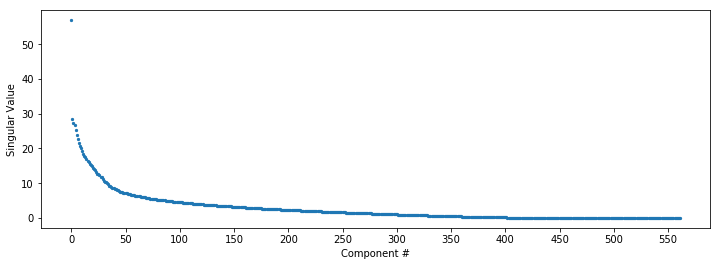

In [29]:
pca = PCA()
pca.fit(X_intx,dat['Outcome'])
## Plot the singular values
plt.figure(figsize = (12,4))
plt.scatter(x = list(range(pca.singular_values_.size)), y = pca.singular_values_, s = 5)
_ = plt.xlabel('Component #')
_ = plt.ylabel('Singular Value')
_ = plt.xticks(np.arange(0,X_intx.shape[1]+1,50))

We see an elbow in the graph around 35-45 components. Let's see how accurate our interaction model is when we significantly cut down the number of dimensions.

In [31]:
pca = PCA(n_components = 40)
X40 = pca.fit_transform(X_intx,dat['Outcome'])
X40_train, X40_test, y40_train, y40_test = train_test_split(X40, dat['Outcome'], test_size=0.2)
clf = LogisticRegressionCV(cv=10)
clf.fit(X40_train,y40_train)
pred40 = clf.predict(X40_test)
print('Cross validation score: %.2f' % 
      cross_val_score(clf, X40, dat['Outcome'], cv=10).mean())
print('\n')
print(confusion_matrix(y40_test,pred40))
print('\n')
print(classification_report(y40_test,pred40))

Cross validation score: 0.75


[[56 18]
 [24 51]]


             precision    recall  f1-score   support

          0       0.70      0.76      0.73        74
          1       0.74      0.68      0.71        75

avg / total       0.72      0.72      0.72       149



So, we've now used feature interactions to expand our model, and then PCA to reduce it back to about its original size. The change in accuracy wasn't too significant, but the result is a richer model.

The next step is to try a different model algorithm to see if we can really push the accuracy - random forests, and eventually gradient boosting.

### Model 2: Random Forest

Because all our features are booleans, we can create simple decision trees for classifying the outcome of a point.

We will try a random forest classifier using our original features, our interactions-augmented features, and our PCA-reduced-interactions features.

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
X_train, X_test, y_train, y_test = train_test_split(dat.drop(['Duration','Passes','Points Played','Possessions','Outcome'], axis=1), dat['Outcome'], test_size=0.2, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print('Cross validation score: %.2f' % 
      cross_val_score(clf, dat.drop(['Duration','Passes','Points Played','Possessions','Outcome'], axis=1), dat['Outcome'], cv=10).mean())
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

Cross validation score: 0.64


[[45 20]
 [27 57]]


             precision    recall  f1-score   support

          0       0.62      0.69      0.66        65
          1       0.74      0.68      0.71        84

avg / total       0.69      0.68      0.69       149



The standard random forest model isn't too accurate, at least not as accurate as the logistic regression model. Next, we'll try the same model with degree 2 interaction features.

In [34]:
intx_generator = PolynomialFeatures(degree = 3, interaction_only = True, include_bias = False)
X_intx = intx_generator.fit_transform(dat.drop(['Duration','Passes','D Line','Possessions','Outcome','Points Played'], axis=1))
X_intx = pd.DataFrame(X_intx).join(dat['D Line'])
Xintx_train, Xintx_test, yintx_train, yintx_test = train_test_split(X_intx, dat['Outcome'], test_size=0.2)
clf = RandomForestClassifier()
clf.fit(Xintx_train,yintx_train)
pred_intx = clf.predict(Xintx_test)
print('Cross validation score: %.2f' % 
      cross_val_score(clf, X_intx, dat['Outcome'], cv=10).mean())
print('\n')
print(confusion_matrix(yintx_test,pred_intx))
print('\n')
print(classification_report(yintx_test,pred_intx))

Cross validation score: 0.66


[[50 16]
 [32 51]]


             precision    recall  f1-score   support

          0       0.61      0.76      0.68        66
          1       0.76      0.61      0.68        83

avg / total       0.69      0.68      0.68       149



The extra features didn't seem to help. Lastly, we'll try a random forest after reducing the features with PCA.

In [35]:
pca = PCA(n_components = 40)
X40 = pca.fit_transform(X_intx,dat['Outcome'])
X40_train, X40_test, y40_train, y40_test = train_test_split(X40, dat['Outcome'], test_size=0.2)
clf = LogisticRegressionCV(cv=10)
clf.fit(X40_train,y40_train)
pred40 = clf.predict(X40_test)
print('Cross validation score: %.2f' % 
      cross_val_score(clf, X40, dat['Outcome'], cv=10).mean())
print('\n')
print(confusion_matrix(y40_test,pred40))
print('\n')
print(classification_report(y40_test,pred40))

Cross validation score: 0.75


[[59 16]
 [19 55]]


             precision    recall  f1-score   support

          0       0.76      0.79      0.77        75
          1       0.77      0.74      0.76        74

avg / total       0.77      0.77      0.76       149



So overall, the random forest model hasn't really helped us. The PCA-reduced-interaction model has given us the best performance, but it is still about on-par with logistic regression.

The last model we will try is a gradient-boosting model using xgboost.

### Model 3: Gradient Boost (XGBoost)

Again, we will try XGBoost with 3 formats: standard features, interactions-augmented features, and PCA-reduced interactions features.

In [36]:
from xgboost import XGBClassifier

In [37]:
X_train, X_test, y_train, y_test = train_test_split(dat.drop(['Duration','Passes','Points Played','Possessions','Outcome'], axis=1), dat['Outcome'], test_size=0.2)
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
print('Cross validation score: %.2f' % 
      cross_val_score(xgb, dat.drop(['Duration','Passes','Points Played','Possessions','Outcome'], axis=1), dat['Outcome'], cv=10).mean())
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

Cross validation score: 0.71


[[59 20]
 [15 55]]


             precision    recall  f1-score   support

          0       0.80      0.75      0.77        79
          1       0.73      0.79      0.76        70

avg / total       0.77      0.77      0.77       149



The accuracy is a fair bit better than the random forest model, but is still only on par with the logistic regression model. Next, we try XGBoost with interaction terms.

In [39]:
intx_generator = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
X_intx = intx_generator.fit_transform(dat.drop(['Duration','Passes','D Line','Possessions','Outcome','Points Played'], axis=1))
X_intx = pd.DataFrame(X_intx).join(dat['D Line'])
Xintx_train, Xintx_test, yintx_train, yintx_test = train_test_split(X_intx, dat['Outcome'], test_size=0.2)
xgb = XGBClassifier()
xgb.fit(Xintx_train,yintx_train)
pred_intx = xgb.predict(Xintx_test)
print('Cross validation score: %.2f' % 
      cross_val_score(xgb, X_intx, dat['Outcome'], cv=10).mean())
print('\n')
print(confusion_matrix(yintx_test,pred_intx))
print('\n')
print(classification_report(yintx_test,pred_intx))

Cross validation score: 0.71


[[58 20]
 [13 58]]


             precision    recall  f1-score   support

          0       0.82      0.74      0.78        78
          1       0.74      0.82      0.78        71

avg / total       0.78      0.78      0.78       149



As we have seen previously, the features-augmented scheme alone doesn't help our model. We'll see what happens when we apply PCA to these features.

In [40]:
pca = PCA(n_components = 40)
X40 = pca.fit_transform(X_intx,dat['Outcome'])
X40_train, X40_test, y40_train, y40_test = train_test_split(X40, dat['Outcome'], test_size=0.2)
xgb = XGBClassifier()
xgb.fit(X40_train,y40_train)
pred40 = xgb.predict(X40_test)
print('Cross validation score: %.2f' % 
      cross_val_score(clf, X40, dat['Outcome'], cv=10).mean())
print('\n')
print(confusion_matrix(y40_test,pred40))
print('\n')
print(classification_report(y40_test,pred40))

Cross validation score: 0.75


[[59 22]
 [16 52]]


             precision    recall  f1-score   support

          0       0.79      0.73      0.76        81
          1       0.70      0.76      0.73        68

avg / total       0.75      0.74      0.75       149



So overall, XGBoost hasn't really improved our results from the original logistic regression model.

## Conclusion

We set out to predict the outcome of a point using only the 7 players called on the point. After examining three different algorithms (logistic regression, random forests, gradient boost) and three different feature transformations (no transformation, degree 2 interactions, degree 2 interactions reduced by PCA), I would choose the logistic regression with the PCA reduced features model.

In reality, logistic regresion and gradient boosting performed similarly. However, logistic regression has the benefit of producing a coefficient vector that provides some additional insight into the players on a team (up to some interpretation).

Through feature selection, we were also able to learn that the number of points played prior to a point has little effect on determining its outcome. That means that, whether it's at the start or end of a game, the players on the field and whether it's an O or D point are the most important predictors of the outcome.

Out of the three feature transformations, the PCA reduced features seemed to perform the best. It equaled or outperformed the original features despite being approximately the same dimension, which implies that the interaction terms were of some value (even though the non-reduced interaction terms performed worse).

Overall, none of our models were able to reliably break the 80% accuracy threshold. I would reason that this is the highest we can expect when working with sports data; there are many more variables at play that determine the outcome of a point than just the players on the field (ex: the opposing team, weather). In addition, sports data is highly subject to random noise: the 7 strongest players on the team aren't going to score 100% of the time they are on a line, because that's just how sports works.

The fact that we can hit upwards of 75% accuracy with a mostly impractical model is already somewhat impressive. The real insight from this analysis comes from the logistic regression coefficients, which are able to assign (somewhat accurate) 1-dimensional values to the players on a team, and "rank" them by their contribution. While this is also impractical (and to some degree, unethical, to reduce a human player down to a number), it can be useful.